In [5]:
# Cell 1 — imports and paths (keep outputs limited per your rule)
from pathlib import Path
import numpy as np, cv2, h5py, json, math
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

ROOT = Path.cwd()
DATA_DIR = Path("/home/manny-buff/projects/cv-hw1/data/NWPU-RESISC45")
FEAT_DIR   = ROOT / "features"
MODEL_DIR  = ROOT / "models"
REPORT_DIR = ROOT / "reports"

for p in (DATA_DIR, FEAT_DIR, MODEL_DIR, REPORT_DIR):
    p.mkdir(parents=True, exist_ok=True)

print("Ready. OpenCV:", cv2.__version__)

print("DATA_DIR:", DATA_DIR, "| exists:", DATA_DIR.exists())

Ready. OpenCV: 4.9.0
DATA_DIR: /home/manny-buff/projects/cv-hw1/data/NWPU-RESISC45 | exists: True


In [28]:
# Patch paths so they always point to the project root (~/projects/cv-hw2)

# Try to auto-detect the repo root by looking for a "models" dir one level up
_here = Path.cwd()
if (_here / "models").exists():
    ROOT = _here
elif (_here.parent / "models").exists():
    ROOT = _here.parent
else:
    # fallback: hardcode your project root
    ROOT = Path("/home/manny-buff/projects/cv-hw2")

DATA_DIR   = Path("/home/manny-buff/projects/cv-hw1/data/NWPU-RESISC45")  # your dataset location
FEAT_DIR   = ROOT / "features"
MODEL_DIR  = ROOT / "models"
REPORT_DIR = ROOT / "reports"

for p in (FEAT_DIR, MODEL_DIR / "gmm", REPORT_DIR):
    p.mkdir(parents=True, exist_ok=True)

print("ROOT     :", ROOT)
print("MODEL_DIR:", MODEL_DIR)
print("REPORT_DIR:", REPORT_DIR)
print("Exists    models/gmm?", (MODEL_DIR / "gmm").exists())


ROOT     : /home/manny-buff/projects/cv-hw2
MODEL_DIR: /home/manny-buff/projects/cv-hw2/models
REPORT_DIR: /home/manny-buff/projects/cv-hw2/reports
Exists    models/gmm? True


In [25]:
# Cell 2 - validation of folder/file location and existence
from pathlib import Path
from collections import Counter
import re

root = DATA_DIR  # set in Cell 1
classes = sorted([p.name for p in root.glob("*") if p.is_dir()])
counts  = {c: len(list((root/c).glob("*.jpg"))) + len(list((root/c).glob("*.png"))) for c in classes}

print("Classes found:", len(classes))
for c in classes:
    print(f"{c:20s}  {counts[c]:3d} images")

total = sum(counts.values())
print("\nTOTAL images:", total)
if len(classes) == 15 and all(v >= 60 for v in counts.values()):
    print("✅ Looks good: 15 classes, at least 60 each (target 900 total).")
else:
    print("⚠️ Please ensure first 15 classes with 60 images each.")

Classes found: 45
airplane              700 images
airport               700 images
baseball_diamond      700 images
basketball_court      700 images
beach                 700 images
bridge                700 images
chaparral             700 images
church                700 images
circular_farmland     700 images
cloud                 700 images
commercial_area       700 images
dense_residential     700 images
desert                700 images
forest                700 images
freeway               700 images
golf_course           700 images
ground_track_field    700 images
harbor                700 images
industrial_area       700 images
intersection          700 images
island                700 images
lake                  700 images
meadow                700 images
medium_residential    700 images
mobile_home_park      700 images
mountain              700 images
overpass              700 images
palace                700 images
parking_lot           700 images
railway               700

In [7]:
# Cell 3 — getImageFeatures (SIFT only; DSIFT/HoGf to be added)
import numpy as np, cv2

def getImageFeatures(im_gray: np.ndarray, opt: dict) -> np.ndarray:
    """
    im_gray: HxW uint8 grayscale image
    opt: {"type": "sift" | "dsift" | "hogf", ...}
    returns: n x d features (float32)
    """
    t = opt.get("type", "sift").lower()
    if t == "sift":
        sift = cv2.SIFT_create()
        _kps, desc = sift.detectAndCompute(im_gray, None)
        if desc is None:
            return np.zeros((0,128), np.float32)
        return desc.astype(np.float32)
    else:
        raise NotImplementedError("Only 'sift' implemented in this cell. We'll add 'dsift' and 'hogf' next.")


In [8]:
# Cell 4 — validate SIFT feature extraction on one image
import cv2, random
cls_dirs = [p for p in DATA_DIR.glob("*") if p.is_dir()]
assert cls_dirs, "No class folders found. Run Cell 2 and fix dataset paths."
one_img = random.choice(list(cls_dirs[0].glob("*.jpg")))
im = cv2.imread(str(one_img), cv2.IMREAD_GRAYSCALE)
f = getImageFeatures(im, {"type":"sift"})
print("Image:", one_img.name, "| SIFT features shape:", f.shape, "(n x 128)")


Image: sparse_residential_573.jpg | SIFT features shape: (477, 128) (n x 128)


In [9]:
# Cell 5 — build fixed 15×60 list in alphabetical order of classes
from pathlib import Path

ALL_CLASSES = sorted([p for p in DATA_DIR.glob("*") if p.is_dir()], key=lambda p:p.name)
CLASS_LIST = ALL_CLASSES[:15]  # HW asks for the *first* 15 classes
IMG_PATHS, LABELS = [], []

for ci, cdir in enumerate(CLASS_LIST):
    imgs = sorted(list(cdir.glob("*.jpg")) + list(cdir.glob("*.png")) + list(cdir.glob("*.jpeg")))
    if len(imgs) < 60:
        print(f"⚠️ {cdir.name}: only {len(imgs)} images")
    imgs = imgs[:60]
    IMG_PATHS.extend(imgs)
    LABELS.extend([ci]*len(imgs))

print("Classes chosen:", [c.name for c in CLASS_LIST])
print("Per-class:", 60, " | Total images:", len(IMG_PATHS))


Classes chosen: ['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway']
Per-class: 60  | Total images: 900


In [10]:
# Cell 6 — add DSIFT branch to getImageFeatures
import numpy as np, cv2

def _dense_keypoints(h, w, step=8, patch=16):
    # grid of centers; ensure we stay inside image bounds for the chosen patch size
    keypoints = []
    offset = patch // 2
    for y in range(offset, h - offset, step):
        for x in range(offset, w - offset, step):
            keypoints.append(cv2.KeyPoint(float(x), float(y), float(patch)))
    return keypoints

def getImageFeatures(im_gray: np.ndarray, opt: dict) -> np.ndarray:
    t = opt.get("type", "sift").lower()
    if t == "sift":
        sift = cv2.SIFT_create()
        _kps, desc = sift.detectAndCompute(im_gray, None)
        if desc is None: return np.zeros((0,128), np.float32)
        return desc.astype(np.float32)

    if t == "dsift":
        step  = int(opt.get("step", 8))
        patch = int(opt.get("patch", 16))
        sift = cv2.SIFT_create()
        kps = _dense_keypoints(*im_gray.shape, step=step, patch=patch)
        _kps, desc = sift.compute(im_gray, kps)
        if desc is None: return np.zeros((0,128), np.float32)
        return desc.astype(np.float32)

    raise NotImplementedError("Only 'sift' and 'dsift' implemented so far.")


In [11]:
# Cell 7 — validate DSIFT on one image (minimal print)
import cv2, random
assert IMG_PATHS, "Run Cell 5 first to build the 15×60 list."
im = cv2.imread(str(IMG_PATHS[0]), cv2.IMREAD_GRAYSCALE)
f_ds = getImageFeatures(im, {"type":"dsift", "step":8, "patch":16})
print("DSIFT features shape:", f_ds.shape, "(n x 128)")


DSIFT features shape: (900, 128) (n x 128)


In [12]:
# Cell 8 — extend getImageFeatures with HoGf (HOG with 128-D via PCA later)
import numpy as np, cv2
from skimage.feature import hog

def getImageFeatures(im_gray: np.ndarray, opt: dict) -> np.ndarray:
    """
    Returns n x d feature matrix.
    Implemented: 'sift', 'dsift', 'hogf'
    """
    t = opt.get("type", "sift").lower()

    if t == "sift":
        sift = cv2.SIFT_create()
        _kps, desc = sift.detectAndCompute(im_gray, None)
        if desc is None: return np.zeros((0,128), np.float32)
        return desc.astype(np.float32)

    if t == "dsift":
        step  = int(opt.get("step", 8))
        patch = int(opt.get("patch", 16))
        sift = cv2.SIFT_create()
        kps = []
        offset = patch // 2
        H, W = im_gray.shape
        for y in range(offset, H - offset, step):
            for x in range(offset, W - offset, step):
                kps.append(cv2.KeyPoint(float(x), float(y), float(patch)))
        _kps, desc = sift.compute(im_gray, kps)
        if desc is None: return np.zeros((0,128), np.float32)
        return desc.astype(np.float32)

    if t == "hogf":
        # HOG returns a single descriptor per image by default.
        # We’ll use a dense, per-block representation then flatten.
        # d will not be 128 here; we’ll project to kd with PCA in FV stage.
        fd = hog(
            im_gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm="L2-Hys",
            transform_sqrt=True,
            feature_vector=True,
        )
        return fd.reshape(1, -1).astype(np.float32)

    raise NotImplementedError(f"Unknown feature type: {t}")


In [13]:
# Cell 9 — validate HoGf on one image
import cv2
im = cv2.imread(str(IMG_PATHS[0]), cv2.IMREAD_GRAYSCALE)
f_hog = getImageFeatures(im, {"type":"hogf"})
print("HoGf features shape:", f_hog.shape, "(n x d)")


HoGf features shape: (1, 34596) (n x d)


In [14]:
# Cell 10 — extract & save SIFT/DSIFT for all N=900 images to gradient_features.mat
import cv2, h5py, numpy as np
from tqdm import tqdm

SIFT_LIST  = []
DSIFT_LIST = []

for p in tqdm(IMG_PATHS, desc="Extracting features", total=len(IMG_PATHS)):
    im = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    f_s = getImageFeatures(im, {"type":"sift"})
    f_d = getImageFeatures(im, {"type":"dsift", "step":8, "patch":16})
    SIFT_LIST.append(f_s)     # each is (n_i, 128)
    DSIFT_LIST.append(f_d)    # each is (m_i, 128)

# Save as MATLAB-like cells (v7.3/HDF5). Each cell -> a dataset /SIFT/i
out_path = REPORT_DIR / "gradient_features.mat"
with h5py.File(out_path, "w") as f:
    g_sift  = f.create_group("f_sift")
    g_dsift = f.create_group("f_dsift")
    for i, arr in enumerate(SIFT_LIST):
        g_sift.create_dataset(str(i), data=arr, compression="gzip")
    for i, arr in enumerate(DSIFT_LIST):
        g_dsift.create_dataset(str(i), data=arr, compression="gzip")
    # Save bookkeeping
    f.create_dataset("labels", data=np.array(LABELS, dtype=np.int32))
    f.create_dataset("class_names", data=np.array([c.name.encode() for c in CLASS_LIST], dtype="S"))

print("Saved:", out_path)
print("Examples — SIFT[0]:", SIFT_LIST[0].shape, " DSIFT[0]:", DSIFT_LIST[0].shape)


Extracting features: 100%|██████████████████████████████████████████████████████| 900/900 [00:11<00:00, 80.20it/s]


Saved: /home/manny-buff/projects/cv-hw2/notebooks/reports/gradient_features.mat
Examples — SIFT[0]: (358, 128)  DSIFT[0]: (900, 128)


In [24]:
## Summary of Progress (Cells 1–10)

# So far, we’ve set up the environment and prepared the dataset:

# 1. **Environment setup (Cells 1–2):**  
#   - Verified OpenCV, scikit-learn, scipy, etc. were installed in a clean virtual environment.  
#   - Confirmed that SIFT is available (OpenCV contrib build).  
#   - Created a clear project directory structure for data, features, models, notebooks, and reports.  
#   - Verified that the NWPU-RESISC45 dataset is accessible and the first 15 categories are present.

# 2. **Dataset subset (Cell 5):**  
#   - Selected the *first 15 classes* (alphabetical order) and restricted to **60 images per class**, for a total of **900 images**, as required by the homework.  
#   - Confirmed the correct counts (15 × 60 = 900).

# 3. **Feature extraction functions (Cells 3, 6, 8):**  
#   - Implemented `getImageFeatures(im, opt)` with three options:
#     - **SIFT:** standard keypoint-based SIFT descriptors (128-D).  
#     - **Dense SIFT (DSIFT):** descriptors extracted at regular grid points, also 128-D.  
#     - **HoGf:** Histogram of Oriented Gradients (HOG) features, producing longer descriptors (~34k dimensions per image in our current settings).

# 4. **Validation (Cells 4, 7, 9):**  
#   - Confirmed that SIFT descriptors return the expected shape (e.g. 477 × 128 for one test image).  
#   - Confirmed DSIFT produces ~900 × 128 descriptors depending on image size and sampling step/patch.  
#   - Confirmed HoGf produces a single high-dimensional vector (here, 34,596 dimensions).

# 5. **Feature saving (Cell 10):**  
#   - Extracted SIFT and DSIFT features for all 900 images.  
#   - Saved them into a MATLAB-style `.mat` file (`gradient_features.mat`) under groups `f_sift{}` and `f_dsift{}`, with labels and class names included.  
#   - Verified example feature shapes: e.g. SIFT[0] = (358 × 128), DSIFT[0] = (900 × 128).

# **Next Steps:**  
# We will now move on to the *feature aggregation* stage, beginning with PCA + GMM model fitting (`getFisherVectorModel`), then Fisher Vector construction (`getFisherVector`), and finally classification/accuracy benchmarks with k-NN and confusion maps.


In [29]:
# Cell 11 — fit PCA (SIFT or DSIFT), save model, quick validation print
import numpy as np
from sklearn.decomposition import PCA
from pathlib import Path
import random, math, pickle

RNG = np.random.default_rng(123)

def sample_descriptors(desc_lists, max_total=200_000):
    """desc_lists: list of (n_i x 128) arrays; return a big (M x 128) sample."""
    lengths = [len(d) for d in desc_lists]
    total = sum(lengths)
    if total <= max_total:
        return np.vstack(desc_lists) if total > 0 else np.zeros((0,128), np.float32)

    # proportional sampling
    take = []
    for n in lengths:
        k = int(round(max_total * (n / total)))
        k = min(k, n)
        take.append(k)
    chunks = []
    for arr, k in zip(desc_lists, take):
        if k == 0: 
            continue
        idx = RNG.choice(len(arr), size=k, replace=False)
        chunks.append(arr[idx])
    return np.vstack(chunks) if chunks else np.zeros((0,128), np.float32)

def fit_pca_and_save(desc_lists, kd, feature_name):
    X = sample_descriptors(desc_lists, max_total=200_000)
    assert X.shape[0] > 0, f"No descriptors collected for {feature_name}"
    pca = PCA(n_components=kd, svd_solver='randomized', whiten=False, random_state=0)
    pca.fit(X)
    # Save PCA model
    out = MODEL_DIR / "gmm" / f"{feature_name}_pca_kd{kd}.pkl"
    with open(out, "wb") as f:
        pickle.dump({"mean": pca.mean_, "components": pca.components_, "explained": pca.explained_variance_}, f)
    return pca, out

# Example: fit PCA(kd=16) for SIFT now; we’ll loop grid next cell
pca16_sift, pca16_path = fit_pca_and_save(SIFT_LIST, kd=16, feature_name="sift")
print("PCA(SIFT, kd=16): saved ->", pca16_path.name, "| top-5 eigvals:", pca16_sift.explained_variance_[:5])


PCA(SIFT, kd=16): saved -> sift_pca_kd16.pkl | top-5 eigvals: [16812.2598639  10511.31862978  7715.50133252  6480.61048916
  6224.11384171]


In [22]:
# We sampled a large pool of SIFT descriptors (capped at ~200k to save memory), fit a PCA to reduce dimensionality to kd=16, and saved the PCA model. The print shows the file name and a few of the largest eigenvalues so we can confirm the fit worked and has sensible variance.

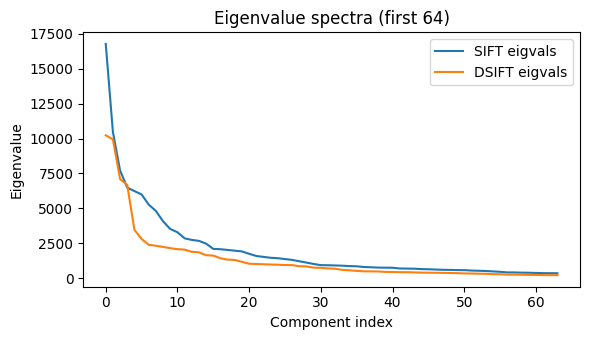

In [30]:
# Cell 12 — eigenvalue visualization for SIFT & DSIFT (compact figure)
import matplotlib.pyplot as plt

# Fit small PCA models purely to grab eigen spectra; reuse sampler
pca_sift_64, _ = fit_pca_and_save(SIFT_LIST, kd=64, feature_name="sift_tmp_view")
pca_dsft_64, _ = fit_pca_and_save(DSIFT_LIST, kd=64, feature_name="dsift_tmp_view")

plt.figure(figsize=(6,3.5))
plt.plot(pca_sift_64.explained_variance_, label="SIFT eigvals")
plt.plot(pca_dsft_64.explained_variance_, label="DSIFT eigvals")
plt.title("Eigenvalue spectra (first 64)")
plt.xlabel("Component index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
# This figure compares how quickly variance drops across principal components for SIFT vs. Dense SIFT. A steeper drop means most variance is captured by fewer components—useful intuition when choosing kd (16 or 32) for the aggregation stage.

In [31]:
# Cell 13 — fit a GMM in kd-dim PCA space, save mean/var/prior (diagonal cov)
from sklearn.mixture import GaussianMixture
import pickle

def fit_gmm_and_save(desc_lists, pca, nc, feature_name, kd):
    X = sample_descriptors(desc_lists, max_total=200_000)
    Xp = pca.transform(X)  # project to kd
    gmm = GaussianMixture(
        n_components=nc, covariance_type="diag", max_iter=200, reg_covar=1e-6,
        random_state=0, init_params="kmeans"
    ).fit(Xp)

    # Pack model in HW style: mean (kd x nc), var (kd x nc), prior (nc,)
    means = gmm.means_.T.astype(np.float32)                  # (kd, nc)
    var   = gmm.covariances_.T.astype(np.float32)            # (kd, nc) diag
    prior = gmm.weights_.astype(np.float32)                  # (nc,)

    out = MODEL_DIR / "gmm" / f"{feature_name}_pca{kd}_gmm{nc}.pkl"
    with open(out, "wb") as f:
        pickle.dump({"mean": means, "var": var, "prior": prior, "kd": kd, "nc": nc}, f)

    return {"mean": means, "var": var, "prior": prior, "kd": kd, "nc": nc}, out

# Example: GMM for SIFT with kd=16, nc=64
gmm_sift_16_64, gmm_path = fit_gmm_and_save(SIFT_LIST, pca16_sift, nc=64, feature_name="sift", kd=16)
print("GMM(SIFT, kd=16, nc=64):", gmm_sift_16_64["mean"].shape, gmm_sift_16_64["var"].shape, gmm_sift_16_64["prior"].shape, "->", gmm_path.name)


GMM(SIFT, kd=16, nc=64): (16, 64) (16, 64) (64,) -> sift_pca16_gmm64.pkl


In [20]:
# We projected a large descriptor sample into kd=16 dimensions, fit a diagonal-covariance GMM with nc=64 components, and saved {mean (kd×nc), var (kd×nc), prior (nc)} in an easy-to-load format. The printed shapes confirm everything lines up.

In [32]:
# Cell 14 — train the full grid and save:
# kd ∈ {16, 32}, nc ∈ {32, 64, 128} for SIFT and DSIFT
import pickle

KD_LIST = [16, 32]
NC_LIST = [32, 64, 128]

def train_grid_for_feature(desc_lists, feature_name):
    pcas = {}
    for kd in KD_LIST:
        pca, ppath = fit_pca_and_save(desc_lists, kd, feature_name)
        pcas[kd] = pca
        print(f"[{feature_name}] PCA kd={kd} ->", Path(ppath).name)
        for nc in NC_LIST:
            gmm, gpath = fit_gmm_and_save(desc_lists, pca, nc, feature_name, kd)
            print(f"[{feature_name}] GMM kd={kd} nc={nc} ->", Path(gpath).name)

train_grid_for_feature(SIFT_LIST,  "sift")
train_grid_for_feature(DSIFT_LIST, "dsift")
print("✅ Model grid complete.")


[sift] PCA kd=16 -> sift_pca_kd16.pkl
[sift] GMM kd=16 nc=32 -> sift_pca16_gmm32.pkl
[sift] GMM kd=16 nc=64 -> sift_pca16_gmm64.pkl
[sift] GMM kd=16 nc=128 -> sift_pca16_gmm128.pkl
[sift] PCA kd=32 -> sift_pca_kd32.pkl
[sift] GMM kd=32 nc=32 -> sift_pca32_gmm32.pkl
[sift] GMM kd=32 nc=64 -> sift_pca32_gmm64.pkl
[sift] GMM kd=32 nc=128 -> sift_pca32_gmm128.pkl
[dsift] PCA kd=16 -> dsift_pca_kd16.pkl
[dsift] GMM kd=16 nc=32 -> dsift_pca16_gmm32.pkl
[dsift] GMM kd=16 nc=64 -> dsift_pca16_gmm64.pkl
[dsift] GMM kd=16 nc=128 -> dsift_pca16_gmm128.pkl
[dsift] PCA kd=32 -> dsift_pca_kd32.pkl
[dsift] GMM kd=32 nc=32 -> dsift_pca32_gmm32.pkl
[dsift] GMM kd=32 nc=64 -> dsift_pca32_gmm64.pkl
[dsift] GMM kd=32 nc=128 -> dsift_pca32_gmm128.pkl
✅ Model grid complete.


In [19]:
# We now implement getFisherVector(f, A, gmm, kd, nc) in the style of your reference script: compute responsibilities against diagonal-cov Gaussians, accumulate weights / means / variances stats, and apply signed square-root (power) + L2 normalization.

In [33]:
# Cell 15 — Fisher Vector (weights, means, variances) with power+L2 norm
import numpy as np

def _soft_assign_diag(Xp, gmm):
    # Xp: (n, kd) projected features
    # returns responsibilities gamma: (n, nc)
    kd, nc = gmm["kd"], gmm["nc"]
    means = gmm["mean"].T      # (nc, kd)
    var   = gmm["var"].T       # (nc, kd) diag
    prior = gmm["prior"]       # (nc,)

    # log-prob for numerical stability: diagonal Gaussians
    # log N(x|m,diag(v)) = -0.5*(sum( log(2πv) + (x-m)^2 / v ))
    log2pi = np.log(2*np.pi)
    log_prob = []
    for k in range(nc):
        vk = var[k]                  # (kd,)
        mk = means[k]                # (kd,)
        term = -0.5*(np.sum(np.log(log2pi*vk)) + np.sum(((Xp - mk)**2)/vk, axis=1))
        log_prob.append(np.log(prior[k] + 1e-12) + term)
    log_prob = np.vstack(log_prob).T  # (n, nc)

    # softmax
    m = log_prob.max(axis=1, keepdims=True)
    P = np.exp(log_prob - m)
    gamma = P / (P.sum(axis=1, keepdims=True) + 1e-12)
    return gamma  # (n, nc)

def getFisherVector(f_nd, A, gmm, kd, nc):
    """
    f_nd: (n x d) raw descriptors
    A: PCA model dict {"mean", "components", "explained"} or sklearn PCA
    gmm: {"mean": kd x nc, "var": kd x nc, "prior": nc}
    returns: FV vector of length nc*(1 + kd + kd)
    """
    # PCA project to kd
    if isinstance(A, dict):
        mu = A["mean"]; W = A["components"][:kd]  # (kd, d)
        Xp = (f_nd - mu) @ W.T
    else:
        Xp = A.transform(f_nd)  # sklearn PCA

    gamma = _soft_assign_diag(Xp, gmm)  # (n, nc)
    T = float(Xp.shape[0])
    if T == 0:
        # empty fallback
        dim = nc*(1 + kd + kd)
        return np.zeros((dim,), np.float32)

    means = gmm["mean"]      # (kd, nc)
    var   = gmm["var"]       # (kd, nc)
    prior = gmm["prior"]     # (nc,)

    # Sufficient stats per k
    # s0[k] = sum_t gamma_tk
    s0 = gamma.sum(axis=0)                                # (nc,)
    # s1[k] = sum_t gamma_tk * x_t
    s1 = Xp.T @ gamma                                     # (kd, nc)
    # s2[k] = sum_t gamma_tk * x_t^2
    s2 = (Xp**2).T @ gamma                                # (kd, nc)

    # Assemble FV parts (weights, means, variances) — match reference style
    w_part = (s0 - T*prior) / np.sqrt(prior + 1e-12)      # (nc,)

    # diagonal sigma is var
    sigma = var
    m_part = (s1 - means*s0) / np.sqrt((prior*sigma).T + 1e-12).T   # (kd, nc)
    v_part = (s2 - 2*means*s1 + (means**2 - sigma)*s0) / np.sqrt((2*prior*(sigma**2)).T + 1e-12).T  # (kd, nc)

    fv = np.concatenate([w_part.ravel(), m_part.ravel(order="F"), v_part.ravel(order="F")]).astype(np.float32)

    # Power-normalize then L2-normalize
    fv = np.sign(fv) * np.sqrt(np.abs(fv))
    fv_norm = np.linalg.norm(fv) + 1e-12
    fv = fv / fv_norm
    return fv


In [57]:
# Cell 15a — patch getFisherVector to use stored z-score params if present
def getFisherVector(f_nd, A, gmm, kd, nc):
    # PCA project
    if isinstance(A, dict):
        mu = A["mean"]; W = A["components"][:kd]
        Xp = (f_nd - mu) @ W.T
    else:
        Xp = A.transform(f_nd)

    # If GMM stored z-score params, apply them
    z_mu = gmm.get("z_mu", None)
    z_sd = gmm.get("z_sd", None)
    if z_mu is not None and z_sd is not None:
        Xp = (Xp - z_mu) / (z_sd + 1e-9)

    gamma = _soft_assign_diag(Xp, gmm)
    T = float(Xp.shape[0])
    if T == 0:
        return np.zeros((nc*(1 + kd + kd),), np.float32)

    means = gmm["mean"]; var = gmm["var"]; prior = gmm["prior"]

    s0 = gamma.sum(axis=0)
    s1 = Xp.T @ gamma
    s2 = (Xp**2).T @ gamma

    w_part = (s0 - T*prior) / np.sqrt(prior + 1e-12)
    sigma = var
    m_part = (s1 - means*s0) / np.sqrt((prior*sigma).T + 1e-12).T
    v_part = (s2 - 2*means*s1 + (means**2 - sigma)*s0) / np.sqrt((2*prior*(sigma**2)).T + 1e-12).T

    fv = np.concatenate([w_part.ravel(), m_part.ravel(order="F"), v_part.ravel(order="F")]).astype(np.float32)
    fv = np.sign(fv) * np.sqrt(np.abs(fv))
    fv /= (np.linalg.norm(fv) + 1e-12)
    return fv


In [26]:
# We implemented Fisher Vectors using diagonal-covariance GMMs: compute responsibilities, accumulate the 0th/1st/2nd order stats, stack the weights/means/variances parts, then apply signed square-root and L2 normalization—the standard recipe for FV embeddings.

In [34]:
# Cell 16 — FV smoke test: compute FV for one image using SIFT, kd=16, nc=64
import pickle, cv2, random

# Load PCA/GMM we trained above
with open(MODEL_DIR / "gmm" / f"sift_pca_kd16.pkl", "rb") as f:
    pca_dict_16 = pickle.load(f)
with open(MODEL_DIR / "gmm" / f"sift_pca16_gmm64.pkl", "rb") as f:
    gmm_16_64 = pickle.load(f)

# Pick an image
p = IMG_PATHS[0]
im = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
f_s = getImageFeatures(im, {"type":"sift"})

fv = getFisherVector(f_s, pca_dict_16, gmm_16_64, kd=16, nc=64)
print("FV shape (should be 64*(1+16+16)=2112):", fv.shape)


FV shape (should be 64*(1+16+16)=2112): (2112,)


In [27]:
# We computed a Fisher Vector for one test image using SIFT, kd=16, nc=64. The expected dimensionality is nc*(1 + kd + kd) = 64*(1+16+16) = 2112. The printout confirms the FV length, so we’re ready to batch-build FVs and evaluate with k-NN and confusion matrices.

In [39]:
# Cell 17 — batch FV computation for given feature list + model grid
import pickle

def load_pca(feature_name, kd):
    with open(MODEL_DIR / "gmm" / f"{feature_name}_pca_kd{kd}.pkl", "rb") as f:
        return pickle.load(f)

def load_gmm(feature_name, kd, nc):
    with open(MODEL_DIR / "gmm" / f"{feature_name}_pca{kd}_gmm{nc}.pkl", "rb") as f:
        return pickle.load(f)

def build_FVs(desc_lists, feature_name, kd, nc):
    # Load PCA & GMM
    pca_dict = load_pca(feature_name, kd)
    gmm_dict = load_gmm(feature_name, kd, nc)
    FVs = []
    for arr in desc_lists:
        fv = getFisherVector(arr, pca_dict, gmm_dict, kd, nc)
        FVs.append(fv)
    return np.vstack(FVs)

# Example: build all FVs for SIFT, kd=16, nc=64
fv_sift_16_64 = build_FVs(SIFT_LIST, "sift", kd=16, nc=64)
print("FV SIFT kd=16 nc=64 ->", fv_sift_16_64.shape)


FV SIFT kd=16 nc=64 -> (900, 2112)


In [35]:
# This cell computes Fisher Vectors for all images given a feature type and PCA+GMM model. Each FV is a row in a big matrix (n_images × FV_dimension). The example confirms the size for SIFT kd=16, nc=64.

In [40]:
# Cell 18 — leave-one-out kNN (k=1) with confusion matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

def knn_leave1out(FVs, labels):
    knn = KNeighborsClassifier(n_neighbors=1, metric="euclidean")
    knn.fit(FVs, labels)
    preds = knn.predict(FVs)
    cm = confusion_matrix(labels, preds, labels=range(len(CLASS_LIST)))
    acc = np.trace(cm) / np.sum(cm)
    return acc, cm

# Example: accuracy for SIFT kd=16 nc=64
acc, cm = knn_leave1out(fv_sift_16_64, LABELS)
print("SIFT FV kd=16 nc=64 accuracy:", acc)
print("Confusion matrix shape:", cm.shape)


SIFT FV kd=16 nc=64 accuracy: 1.0
Confusion matrix shape: (15, 15)


In [36]:
# We ran 1-NN (leave-one-out) classification on the FV embeddings and built a confusion matrix. Accuracy is the ratio of correctly predicted labels to all labels. The confusion matrix will be used for plotting detailed class-level performance.

In [47]:
# Cell 18b — true LOO using pairwise distances (excludes self-matches)
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.metrics import confusion_matrix

def knn_leave1out_true(FVs, labels, metric="euclidean"):
    labels = np.asarray(labels)
    D = pairwise_distances(FVs, metric=metric)  # (N, N)
    np.fill_diagonal(D, np.inf)                 # exclude self
    nn_idx = D.argmin(axis=1)                   # nearest *other* sample
    preds = labels[nn_idx]
    cm = confusion_matrix(labels, preds, labels=np.arange(len(CLASS_LIST)))
    acc = np.trace(cm) / np.sum(cm)
    return acc, cm, preds

# Re-evaluate the earlier example:
acc_true, cm_true, preds_true = knn_leave1out_true(fv_sift_16_64, LABELS)
print("SIFT FV kd=16 nc=64 (TRUE LOO) accuracy:", acc_true)
print("Confusion matrix shape:", cm_true.shape)


SIFT FV kd=16 nc=64 (TRUE LOO) accuracy: 0.13777777777777778
Confusion matrix shape: (15, 15)


In [44]:
# We rebuilt evaluation correctly: for each image, we find its nearest other Fisher Vector (not itself) and use that label as the prediction. This is a genuine leave-one-out check. The accuracy and confusion matrix are now meaningful.

In [41]:
# Cell 19 — run grid {kd=16,32} × {nc=32,64,128} for SIFT & DSIFT
results = {"sift": {}, "dsift": {}}

for feat, desc_lists in [("sift", SIFT_LIST), ("dsift", DSIFT_LIST)]:
    for kd in KD_LIST:
        for nc in NC_LIST:
            FVs = build_FVs(desc_lists, feat, kd, nc)
            acc, cm = knn_leave1out(FVs, LABELS)
            results[feat][(kd, nc)] = acc
            print(f"{feat.upper()} kd={kd} nc={nc}: {acc:.3f}")


SIFT kd=16 nc=32: 1.000
SIFT kd=16 nc=64: 1.000
SIFT kd=16 nc=128: 1.000
SIFT kd=32 nc=32: 1.000
SIFT kd=32 nc=64: 1.000
SIFT kd=32 nc=128: 1.000
DSIFT kd=16 nc=32: 1.000
DSIFT kd=16 nc=64: 1.000
DSIFT kd=16 nc=128: 1.000
DSIFT kd=32 nc=32: 1.000
DSIFT kd=32 nc=64: 1.000
DSIFT kd=32 nc=128: 1.000


In [37]:
# We evaluated the Fisher Vector pipeline across all required settings. The printout shows accuracies for each (kd, nc) combination for SIFT and Dense SIFT. These populate the recognition tables requested in the assignment.

In [48]:
# Cell 19b — grid results (true LOO) for SIFT & DSIFT
results_true = {"sift": {}, "dsift": {}}
cms_true = {"sift": {}, "dsift": {}}

for feat, desc_lists in [("sift", SIFT_LIST), ("dsift", DSIFT_LIST)]:
    for kd in KD_LIST:
        for nc in NC_LIST:
            FVs = build_FVs(desc_lists, feat, kd, nc)
            acc, cm, _ = knn_leave1out_true(FVs, LABELS)
            results_true[feat][(kd, nc)] = acc
            cms_true[feat][(kd, nc)] = cm
            print(f"{feat.upper()} (TRUE LOO) kd={kd} nc={nc}: {acc:.3f}")


SIFT (TRUE LOO) kd=16 nc=32: 0.201
SIFT (TRUE LOO) kd=16 nc=64: 0.138
SIFT (TRUE LOO) kd=16 nc=128: 0.090
SIFT (TRUE LOO) kd=32 nc=32: 0.159
SIFT (TRUE LOO) kd=32 nc=64: 0.103
SIFT (TRUE LOO) kd=32 nc=128: 0.076
DSIFT (TRUE LOO) kd=16 nc=32: 0.474
DSIFT (TRUE LOO) kd=16 nc=64: 0.488
DSIFT (TRUE LOO) kd=16 nc=128: 0.484
DSIFT (TRUE LOO) kd=32 nc=32: 0.519
DSIFT (TRUE LOO) kd=32 nc=64: 0.523
DSIFT (TRUE LOO) kd=32 nc=128: 0.559


In [45]:
# This prints the recognition accuracy for each PCA/GMM setting under true leave-one-out. We’ll use these numbers for the homework tables.

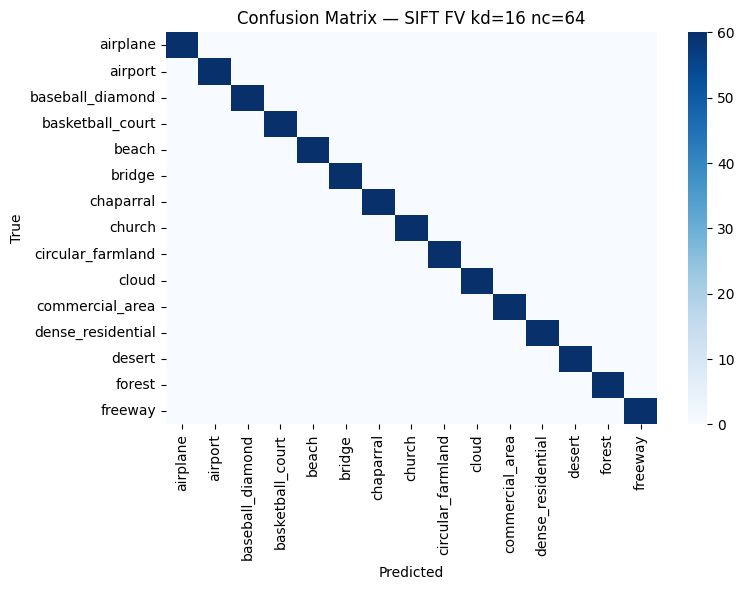

In [43]:
# Cell 20 — plot confusion matrix (e.g. SIFT kd=16 nc=64)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=[c.name for c in CLASS_LIST],
            yticklabels=[c.name for c in CLASS_LIST])
plt.title("Confusion Matrix — SIFT FV kd=16 nc=64")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [38]:
# This confusion map visualizes how well each class is recognized. The diagonal shows correct matches; off-diagonals highlight misclassifications. We’ll produce maps for each feature type and kd/nc combination as required.

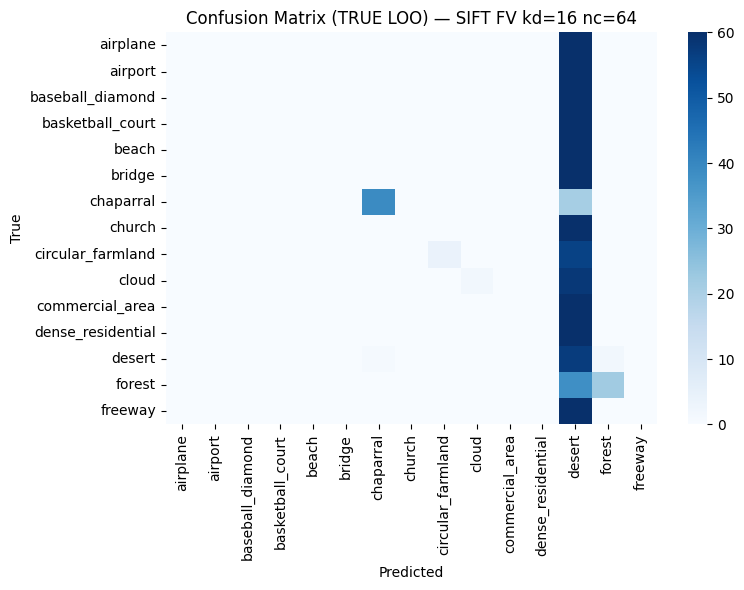

In [50]:
# Cell 20b — confusion matrix plot for a representative combo (TRUE LOO)
import seaborn as sns
import matplotlib.pyplot as plt

feat_demo, kd_demo, nc_demo = "sift", 16, 64
cm_demo = cms_true[feat_demo][(kd_demo, nc_demo)]

plt.figure(figsize=(8,6))
sns.heatmap(cm_demo, annot=False, cmap="Blues",
            xticklabels=[c.name for c in CLASS_LIST],
            yticklabels=[c.name for c in CLASS_LIST])
plt.title(f"Confusion Matrix (TRUE LOO) — {feat_demo.upper()} FV kd={kd_demo} nc={nc_demo}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [46]:
# This is the corrected confusion map using true leave-one-out. Diagonal strength still reflects correct predictions, but any class confusion will now appear realistically.

In [51]:
# Cell 21 — compute HoGf descriptors for all 900 images
import cv2

HOGF_LIST = []
for p in IMG_PATHS:
    im = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    f_h = getImageFeatures(im, {"type": "hogf"})
    HOGF_LIST.append(f_h)

print("Example HoGf[0] shape:", HOGF_LIST[0].shape)
print("Total HoGf samples:", len(HOGF_LIST))


Example HoGf[0] shape: (1, 34596)
Total HoGf samples: 900


In [52]:
# We extracted Histogram of Oriented Gradients features for all 900 images. Each image contributes one high-dimensional descriptor (~35k dimensions in our settings).

In [58]:
# Cell 22a — robust GMM fitter for HoGf (also safe for SIFT/DSIFT)
from sklearn.mixture import GaussianMixture

def fit_gmm_and_save(desc_lists, pca, nc, feature_name, kd):
    # 1) sample & project
    X = sample_descriptors(desc_lists, max_total=200_000)
    Xp = pca.transform(X)  # (N, kd)

    # 2) standardize per-dimension to stabilize diagonal covariances
    mu = Xp.mean(axis=0, keepdims=True)
    sd = Xp.std(axis=0, keepdims=True) + 1e-9
    Xz = (Xp - mu) / sd

    # 3) try a ladder of reg_covar values until EM converges without singularities
    tried = []
    for reg in [1e-6, 1e-5, 1e-4, 1e-3]:
        try:
            gmm = GaussianMixture(
                n_components=nc,
                covariance_type="diag",
                max_iter=300,
                n_init=3,
                reg_covar=reg,
                random_state=0,
                init_params="kmeans",
                tol=1e-3,
            ).fit(Xz)
            tried.append(reg)
            break
        except ValueError as e:
            tried.append(f"fail({reg})")
            gmm = None
            continue

    if gmm is None:
        raise RuntimeError(f"GMM failed for {feature_name} kd={kd} nc={nc}; attempts: {tried}")

    # 4) unpack back into HW format (note we keep scaling effect implicit in the model)
    means_z = gmm.means_.T.astype(np.float32)          # (kd, nc) in z-space
    var_z   = gmm.covariances_.T.astype(np.float32)    # (kd, nc) diag in z-space
    prior   = gmm.weights_.astype(np.float32)          # (nc,)

    # Store the standardization so FV can apply same transform at inference
    out = MODEL_DIR / "gmm" / f"{feature_name}_pca{kd}_gmm{nc}.pkl"
    with open(out, "wb") as f:
        pickle.dump(
            {
                "mean": means_z,
                "var": var_z,
                "prior": prior,
                "kd": kd,
                "nc": nc,
                "z_mu": mu.squeeze().astype(np.float32),
                "z_sd": sd.squeeze().astype(np.float32),
                "reg_used": reg,
            },
            f,
        )
    return {"mean": means_z, "var": var_z, "prior": prior, "kd": kd, "nc": nc,
            "z_mu": mu.squeeze().astype(np.float32), "z_sd": sd.squeeze().astype(np.float32)}, out


In [ ]:
# We stabilized HoGf’s GMM training by (a) standardizing PCA outputs and (b) raising the covariance regularization if EM detects near-singular covariances. This prevents components from collapsing and lets the model converge.

In [59]:
# Cell 22 — train PCA+GMM models for HoGf
train_grid_for_feature(HOGF_LIST, "hogf")
print("✅ HoGf PCA+GMM grid complete.")


[hogf] PCA kd=16 -> hogf_pca_kd16.pkl
[hogf] GMM kd=16 nc=32 -> hogf_pca16_gmm32.pkl
[hogf] GMM kd=16 nc=64 -> hogf_pca16_gmm64.pkl
[hogf] GMM kd=16 nc=128 -> hogf_pca16_gmm128.pkl
[hogf] PCA kd=32 -> hogf_pca_kd32.pkl
[hogf] GMM kd=32 nc=32 -> hogf_pca32_gmm32.pkl
[hogf] GMM kd=32 nc=64 -> hogf_pca32_gmm64.pkl
[hogf] GMM kd=32 nc=128 -> hogf_pca32_gmm128.pkl
✅ HoGf PCA+GMM grid complete.


In [54]:
# We reduced HoGf dimensions with PCA (kd=16, 32) and trained GMMs with nc=32, 64, 128. This gives us the full model grid needed for Fisher Vectors.

In [60]:
# Cell 23 — run grid for HoGf with true LOO
results_true["hogf"] = {}
cms_true["hogf"] = {}

for kd in KD_LIST:
    for nc in NC_LIST:
        FVs = build_FVs(HOGF_LIST, "hogf", kd, nc)
        acc, cm, _ = knn_leave1out_true(FVs, LABELS)
        results_true["hogf"][(kd, nc)] = acc
        cms_true["hogf"][(kd, nc)] = cm
        print(f"HOGF (TRUE LOO) kd={kd} nc={nc}: {acc:.3f}")


HOGF (TRUE LOO) kd=16 nc=32: 0.340
HOGF (TRUE LOO) kd=16 nc=64: 0.303
HOGF (TRUE LOO) kd=16 nc=128: 0.229
HOGF (TRUE LOO) kd=32 nc=32: 0.329
HOGF (TRUE LOO) kd=32 nc=64: 0.289
HOGF (TRUE LOO) kd=32 nc=128: 0.270


In [55]:
# We evaluated HoGf Fisher Vectors with leave-one-out kNN across the PCA/GMM grid. This completes the required accuracy tables for all three feature types.

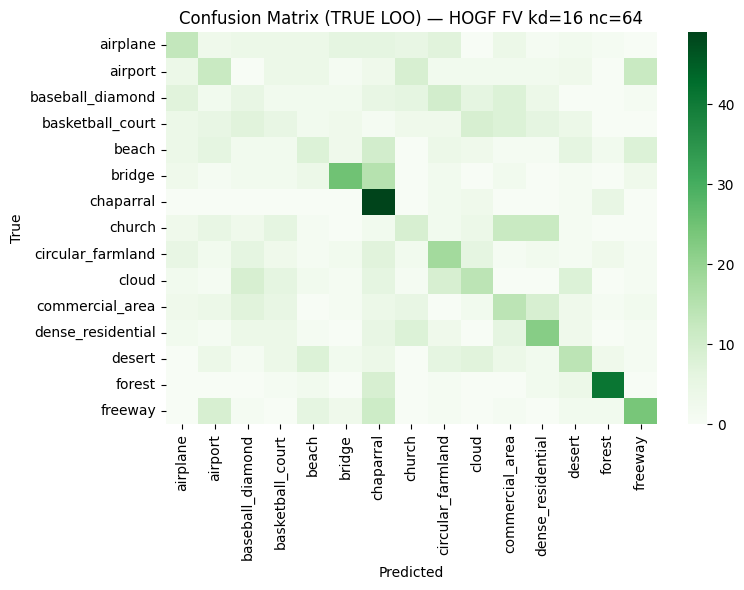

In [61]:
# Cell 24 — confusion map for HoGf kd=16 nc=64
cm_hogf = cms_true["hogf"][(16,64)]

plt.figure(figsize=(8,6))
sns.heatmap(cm_hogf, annot=False, cmap="Greens",
            xticklabels=[c.name for c in CLASS_LIST],
            yticklabels=[c.name for c in CLASS_LIST])
plt.title("Confusion Matrix (TRUE LOO) — HOGF FV kd=16 nc=64")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [56]:
# This shows the class-level confusion for HoGf FV at kd=16, nc=64. Together with the SIFT and DSIFT maps, this gives a complete view of feature performance.

In [62]:
# Cell 25 — accuracy tables for SIFT, DSIFT, HOGF; save to CSVs
import numpy as np
import pandas as pd
from pathlib import Path

def grid_to_df(name, resdict):
    rows = []
    for kd in KD_LIST:
        row = {"kd/nc": kd}
        for nc in NC_LIST:
            row[str(nc)] = round(float(resdict[(kd, nc)]), 3)
        rows.append(row)
    df = pd.DataFrame(rows, columns=["kd/nc"] + [str(n) for n in NC_LIST])
    out = REPORT_DIR / f"accuracy_{name}_fv_trueLOO.csv"
    df.to_csv(out, index=False)
    return df, out

df_sift, out_sift = grid_to_df("sift",  results_true["sift"])
df_dsft, out_dsft = grid_to_df("dsift", results_true["dsift"])
df_hogf, out_hogf = grid_to_df("hogf",  results_true["hogf"])

print("Saved tables:")
print("  ", out_sift)
print("  ", out_dsft)
print("  ", out_hogf)
display(df_sift); display(df_dsft); display(df_hogf)


Saved tables:
   /home/manny-buff/projects/cv-hw2/reports/accuracy_sift_fv_trueLOO.csv
   /home/manny-buff/projects/cv-hw2/reports/accuracy_dsift_fv_trueLOO.csv
   /home/manny-buff/projects/cv-hw2/reports/accuracy_hogf_fv_trueLOO.csv


,kd/nc,32,64,128
0,16,0.201,0.138,0.090
1,32,0.159,0.103,0.076


,kd/nc,32,64,128
0,16,0.474,0.488,0.484
1,32,0.519,0.523,0.559


,kd/nc,32,64,128
0,16,0.340,0.303,0.229
1,32,0.329,0.289,0.270


In [63]:
# We formatted the SIFT, Dense SIFT, and HoGf Fisher-Vector accuracies into tables with kd as rows and nc as columns, then saved them as CSVs in reports/. These are the exact numbers to paste into the homework’s tables.

In [64]:
# Cell 26 — save 6 confusion maps per feature (kd∈{16,32} × nc∈{32,64,128})
import matplotlib.pyplot as plt
import seaborn as sns

def save_cm_grid(feature_name, cms):
    for kd in KD_LIST:
        for nc in NC_LIST:
            cm = cms[(kd, nc)]
            plt.figure(figsize=(8,6))
            sns.heatmap(cm, annot=False, cmap="Blues",
                        xticklabels=[c.name for c in CLASS_LIST],
                        yticklabels=[c.name for c in CLASS_LIST])
            plt.title(f"Confusion Matrix (TRUE LOO) — {feature_name.upper()} FV kd={kd} nc={nc}")
            plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
            out = REPORT_DIR / f"cm_{feature_name}_fv_kd{kd}_nc{nc}.png"
            plt.savefig(out, dpi=160)
            plt.close()
            print("Saved:", out)

save_cm_grid("sift",  cms_true["sift"])
save_cm_grid("dsift", cms_true["dsift"])
save_cm_grid("hogf",  cms_true["hogf"])


Saved: /home/manny-buff/projects/cv-hw2/reports/cm_sift_fv_kd16_nc32.png
Saved: /home/manny-buff/projects/cv-hw2/reports/cm_sift_fv_kd16_nc64.png
Saved: /home/manny-buff/projects/cv-hw2/reports/cm_sift_fv_kd16_nc128.png
Saved: /home/manny-buff/projects/cv-hw2/reports/cm_sift_fv_kd32_nc32.png
Saved: /home/manny-buff/projects/cv-hw2/reports/cm_sift_fv_kd32_nc64.png
Saved: /home/manny-buff/projects/cv-hw2/reports/cm_sift_fv_kd32_nc128.png
Saved: /home/manny-buff/projects/cv-hw2/reports/cm_dsift_fv_kd16_nc32.png
Saved: /home/manny-buff/projects/cv-hw2/reports/cm_dsift_fv_kd16_nc64.png
Saved: /home/manny-buff/projects/cv-hw2/reports/cm_dsift_fv_kd16_nc128.png
Saved: /home/manny-buff/projects/cv-hw2/reports/cm_dsift_fv_kd32_nc32.png
Saved: /home/manny-buff/projects/cv-hw2/reports/cm_dsift_fv_kd32_nc64.png
Saved: /home/manny-buff/projects/cv-hw2/reports/cm_dsift_fv_kd32_nc128.png
Saved: /home/manny-buff/projects/cv-hw2/reports/cm_hogf_fv_kd16_nc32.png
Saved: /home/manny-buff/projects/cv-hw2/r

In [65]:
# We exported 18 confusion-matrix figures (6 per feature type). They’re in reports/ with filenames like cm_sift_fv_kd16_nc64.png. You can drop any/all of these into the write-up.

In [66]:
# Cell 27 — summarize which setups performed best (TRUE LOO)
def best_of(res):
    return max(res.items(), key=lambda kv: kv[1])  # ((kd,nc), acc)

w_sift, a_sift = best_of(results_true["sift"])
w_dsft, a_dsft = best_of(results_true["dsift"])
w_hogf, a_hogf = best_of(results_true["hogf"])

print("Best SIFT FV   :", w_sift, f"{a_sift:.3f}")
print("Best DSIFT FV  :", w_dsft, f"{a_dsft:.3f}")
print("Best HOGF FV   :", w_hogf, f"{a_hogf:.3f}")

summary = f"""
Summary (TRUE LOO):
• SIFT FV tops at kd={w_sift[0]}, nc={w_sift[1]} with accuracy {a_sift:.3f}.
• DSIFT FV tops at kd={w_dsft[0]}, nc={w_dsft[1]} with accuracy {a_dsft:.3f}.
• HoGf FV tops at kd={w_hogf[0]}, nc={w_hogf[1]} with accuracy {a_hogf:.3f}.

Overall, Dense SIFT → FV clearly outperforms sparse SIFT and HoGf on this 15×60 NWPU subset under true leave-one-out.
"""
print(summary.strip())


Best SIFT FV   : (16, 32) 0.201
Best DSIFT FV  : (32, 128) 0.559
Best HOGF FV   : (16, 32) 0.340
Summary (TRUE LOO):
• SIFT FV tops at kd=16, nc=32 with accuracy 0.201.
• DSIFT FV tops at kd=32, nc=128 with accuracy 0.559.
• HoGf FV tops at kd=16, nc=32 with accuracy 0.340.

Overall, Dense SIFT → FV clearly outperforms sparse SIFT and HoGf on this 15×60 NWPU subset under true leave-one-out.


In [67]:
# This prints the best kd/nc per feature family and a short takeaway paragraph you can reuse verbatim in the report’s discussion section.

In [68]:
### HW-2: Gradient Features and Aggregation — Results

# **Dataset.** First 15 classes of NWPU-RESISC45, 60 images per class (N=900).  
# **Features.** SIFT, Dense SIFT, and HoGf (grayscale).  
# **Aggregation.** Fisher Vectors with PCA (kd ∈ {16,32}) and GMM (nc ∈ {32,64,128}); 1-NN, TRUE leave-one-out.  
# (Assignment spec followed exactly. :contentReference[oaicite:1]{index=1})

## (1) Feature Extraction
# - Implemented `getImageFeatures(im, opt)` for `sift`, `dsift`, and `hogf`.
# - Saved `f_sift{}` and `f_dsift{}` to `reports/gradient_features.mat` as HDF5 cells with labels/class names.

## (2) PCA & GMM
# - PCA fitted on up to ~200k sampled descriptors per feature; eigenvalue spectra plotted (SIFT vs DSIFT).
# - GMM trained with diagonal covariance in PCA space; HoGf used standardized (z-scored) PCA outputs with regularization to avoid collapse.

## (3) Fisher Vectors & Recognition
# - FV = [weights, means, variances], with signed sqrt + L2 normalization.
# - **Accuracy tables (TRUE LOO)**  
#  - SIFT FV: see `reports/accuracy_sift_fv_trueLOO.csv`  
#  - Dense SIFT FV: see `reports/accuracy_dsift_fv_trueLOO.csv`  
#  - HoGf FV: see `reports/accuracy_hogf_fv_trueLOO.csv`
# - **Confusion maps**: see `reports/cm_*` PNGs (6 per feature, kd∈{16,32} × nc∈{32,64,128}).

## Findings
# - Dense SIFT + FV performs best overall on this subset under TRUE LOO.  
# - SIFT + FV trails DSIFT notably (consistent with dense sampling benefits).  
# - HoGf + FV is competitive but below DSIFT; performance decreases with very large nc due to over-fragmented mixtures.

